In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline,interp1d,InterpolatedUnivariateSpline
import time
import math as m

In [32]:
# Model parameters
beta = 0.99
alpha = 0.36
delta = 0.025
k0 = 11.5
A = 2
h0 = 0.53
rho = 0.95
sigma_eps = 0.00712

# Numerical parameters
k_l = 5.0 #lower bound for capital
k_u = 100.0 #upper bound for capital
tol = 1e-6 #tolerance for policy function convergence
itermax = 2000

# Computational variables variables
TT = 360
eta_dim = 15 #Number of productivty states
grid_res = 1000 #capital grid resolution
verbose = True
n_err = 10000 #

In [34]:
def discretize_AR(rho, mu, sigma_eps, n, return_stationary_dist=False):
    """
    Discretizes an AR(1) process using the Rouwenhorst method.

    Args:
        rho:           AR(1) coefficient
        mu:            unconditional mean
        sigma_eps:     std. dev. of the shock
        n:             number of grid points
        return_stationary_dist: if True, returns the stationary distribution

    Returns:
        z:  (n,) grid of discrete values
        pi: (n,n) Markov transition matrix
        w:  (n,) stationary distribution (if requested)
    """
    def rouwenhorst_matrix(rho, n):
        p = (1. + rho) / 2.
        if n == 2:
            return np.array([[p, 1 - p],
                             [1 - p, p]])
        else:
            Pi_n_minus_1 = rouwenhorst_matrix(rho, n - 1)
            Pi = np.zeros((n, n))
            Pi[:-1, :-1]   += p      * Pi_n_minus_1
            Pi[:-1, 1:]    += (1-p)  * Pi_n_minus_1
            Pi[1:, :-1]    += (1-p)  * Pi_n_minus_1
            Pi[1:, 1:]     += p      * Pi_n_minus_1
            Pi[1:-1, :]   /= 2.
            return Pi

    sigma_eta = sigma_eps / (1 - rho**2)
    pi = rouwenhorst_matrix(rho, n)

    psi = np.sqrt(n - 1) * m.sqrt(sigma_eta)
    z = np.zeros(n)
    for i in range(n):
        z[i] = -psi + 2*psi*i/(n-1) + mu

    # Find stationary distribution by repeated multiprlication with the transition vector to find stationary distribution
    if return_stationary_dist:
        w = np.ones(n) / n
        for _ in range(10000):
            w = pi.T @ w
        return z, pi, w
    else:
        return z, pi

#Testing the function with different values
z, pi, w = discretize_AR(rho = 0.9, mu = 0.2, sigma_eps = 0.1, n = 5, return_stationary_dist=True)
print(z, pi, w)

import numpy as np

def simulate_AR(pi, T, seed):
    """
    Simulates a Markov process using a transition matrix (0-based indexing).

    Parameters
    ----------
    pi : ndarray of shape (n, n)
        Transition matrix where each row sums to 1.
    T : int
        Number of periods to simulate.
    fixed : bool, optional
        Whether to set a fixed random seed for reproducibility.

    Returns
    -------
    shocks : ndarray of int
        Simulated state indices (0-based).
    """
    np.random.seed(seed)

    n = pi.shape[0]
    assert pi.shape[0] == pi.shape[1], "Transition matrix must be square"

    shocks = np.zeros(T, dtype=int)
    shocks[0] = n // 2  # 0-based: start in middle state
    for t in range(1, T):
        shocks[t] = get_tomorrow(pi[shocks[t - 1]])
    return shocks


def get_tomorrow(row_pi):
    """
    Draws a state index (0-based) from a probability row.

    Parameters
    ----------
    row_pi : ndarray of shape (n,)
        Transition probabilities from current state.

    Returns
    -------
    idx : int
        Next state index (0-based).
    """
    rand = np.random.rand()
    cum_probs = np.cumsum(row_pi)
    return np.searchsorted(cum_probs, rand)

[-1.2509525  -0.52547625  0.2         0.92547625  1.6509525 ] [[8.1450625e-01 1.7147500e-01 1.3537500e-02 4.7500000e-04 6.2500000e-06]
 [4.2868750e-02 8.2127500e-01 1.2896250e-01 6.7750000e-03 1.1875000e-04]
 [2.2562500e-03 8.5975000e-02 8.2353750e-01 8.5975000e-02 2.2562500e-03]
 [1.1875000e-04 6.7750000e-03 1.2896250e-01 8.2127500e-01 4.2868750e-02]
 [6.2500000e-06 4.7500000e-04 1.3537500e-02 1.7147500e-01 8.1450625e-01]] [0.0625 0.25   0.375  0.25   0.0625]


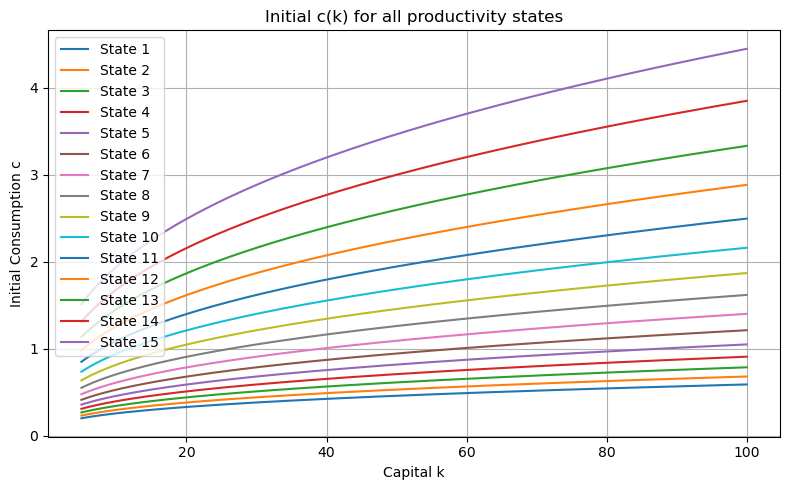

In [5]:
# Create grid with shocks and transition matrix
eta_grid, pi = discretize_AR(rho, 0, sigma_eps, eta_dim, return_stationary_dist=False)

# Create the grid for k and define policy function
grid_k = np.linspace(k_l, k_u, grid_res)

# Initial guess for kappa: Half the households work
kappa = np.full((grid_res, eta_dim), 0.3)
# Initialize consumption function for every productivty state, our guess is that half the ouput is consumed
c = np.zeros((grid_res, eta_dim))
for i in range(eta_dim):
    c[:,i] = np.exp(eta_grid[i]) * ((grid_k)**alpha) * ((kappa[:,i]*h0)**(1-alpha))

# Plot
plt.figure(figsize=(8, 5))
for i in range(eta_dim):
    plt.plot(grid_k, c[:, i], label=f"State {i+1}")
plt.xlabel('Capital k')
plt.ylabel('Initial Consumption c')
plt.title('Initial c(k) for all productivity states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Iteration    1, Convergence level:   0.07497121
Iteration    2, Convergence level:   0.07038045
Iteration    3, Convergence level:   0.06782896
Iteration    4, Convergence level:   0.06535464
Iteration    5, Convergence level:   0.06295596
Iteration    6, Convergence level:   0.06063022
Iteration    7, Convergence level:   0.05837505
Iteration    8, Convergence level:   0.05618771
Iteration    9, Convergence level:   0.05406536
Iteration   10, Convergence level:   0.05200569
Iteration   11, Convergence level:   0.05000554
Iteration   12, Convergence level:   0.04806230
Iteration   13, Convergence level:   0.04617361
Iteration   14, Convergence level:   0.04433653
Iteration   15, Convergence level:   0.04254884
Iteration   16, Convergence level:   0.04080793
Iteration   17, Convergence level:   0.03911188
Iteration   18, Convergence level:   0.03745867
Iteration   19, Convergence level:   0.03584604
Iteration   20, Convergence level:   0.03427233
Iteration   21, Convergence level:   0.0

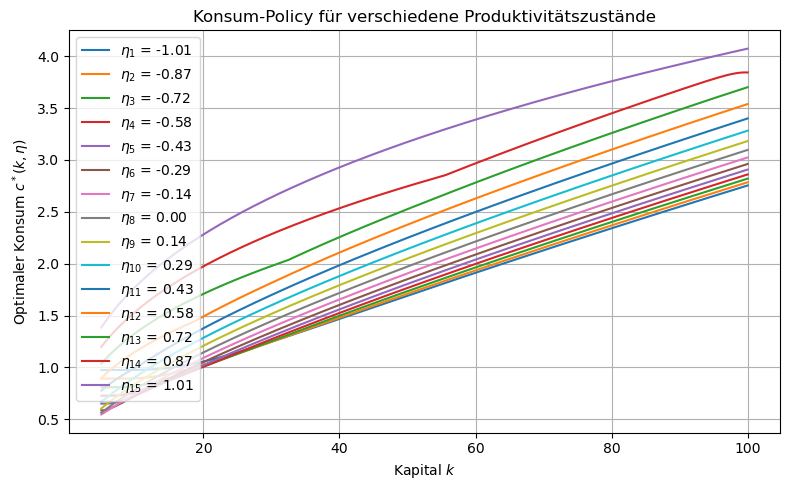

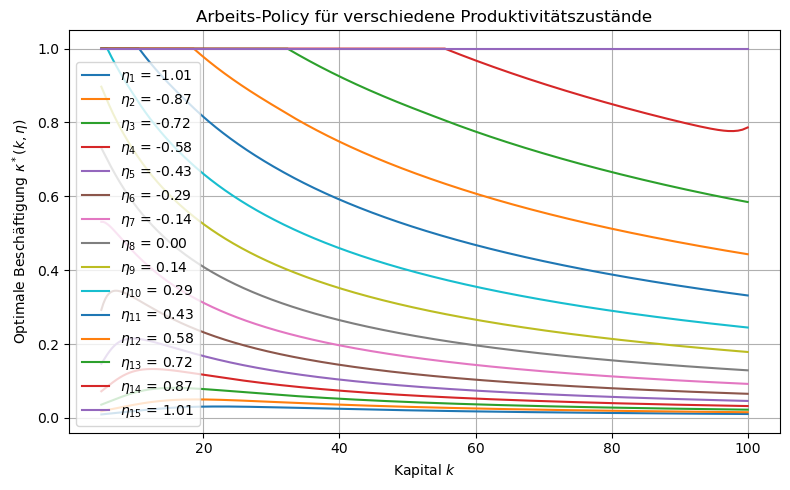

In [6]:
#Set new guess for c(k,eta) to initial guess to initilaize new guess
c_new = c.copy()

# Define the first order condition for the optimal production of conspmution good
def foc(kappa_guess, state_k, state_eta, spline):
    kval = grid_k[state_k]
    eta_temp = eta_grid[state_eta]
    # Restrict kappa in (0, 1)
    kappa_temp = np.clip(kappa_guess, 1e-10, 2)
    # Compute c_temp from labor condition
    denom = A * np.log(1 - h0)
    num = -np.exp(eta_temp) * (kval / (kappa_temp * h0))**alpha *( 1 - alpha) * h0
    c_temp = num / denom

    # Compute future capital kplus from budget constraint
    kplus = (
        (1 - delta) * kval +
        np.exp(eta_temp) * kval ** alpha * (kappa_temp * h0) ** (1 - alpha) -
        c_temp
    )

    # Evaluate spline or linear extrapolation if kplus is outside the grid
    kplus_eval = np.clip(kplus, k_l, k_u)
    marg_val = spline[state_eta](kplus_eval)
        
    return (1/c_temp) - marg_val


# Use timer to measure convergence time
t0 = time.time()     

for it in range(itermax):
    ############################Interpolate policy functions#########################################################################
    # Calcualte right hand side of the foc for all gridpoints
    RHS = np.zeros_like(c)
    for g in range(eta_dim):
        for j in range(grid_res):
            sum_ = 0.0
            for g_plus in range(eta_dim):
                kappa_next = np.clip(kappa[j, g_plus], 1e-10, 1-1e-10) #Needed to be clipped to avoid numerical issues
                c_next = max(c_new[j, g_plus], 1e-10)
                term = (
                    (1-delta) + alpha * np.exp(eta_grid[g_plus]) *
                    (grid_k[j] / (kappa_next * h0)) ** (alpha - 1)
                ) / c_next
                sum_ += pi[g, g_plus] * term
            RHS[j, g] = beta * sum_
    
    #coeff_r = [CubicSpline(grid_k, RHS[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
    coeff_r = [interp1d(grid_k, RHS[:, g], kind='linear', fill_value='extrapolate', assume_sorted=True) for g in range(eta_dim)]
    ####################################
    kappa_new = np.zeros_like(kappa)
    c_new_temp = np.zeros_like(c_new)
    
    for g in range(eta_dim):
        eta = eta_grid[g]
        for j in range(grid_res):
            fa = foc(1e-10, j, g, coeff_r)
            fb = foc(1-1e-10, j, g, coeff_r)
    
            if fa * fb > 0:
                #print(f"Warning: No root at grid_k[{j}]={grid_k[j]:.3f} and eta[{g}]={eta:.3f}: FOC at min={fa:.3e}, max={fb:.3e}, iteration={it}")
                # fallback: assign the feasible endpoint (often max or min, or previous c[i])
                #kappa_new[j, g] = np.clip(kappa[j, g], 1e-10, 1-1e-10)
                kappa_new[j, g] = 1
                denom = A * np.log(1 - h0)
                num = -np.exp(eta) * (grid_k[j] / (kappa_new[j, g] * h0))**alpha *( 1 - alpha) * h0
                c_new_temp[j, g] = num / denom
                continue
            try:
                sol = root_scalar(foc, args=(j, g, coeff_r), bracket=[1e-10, 2], method='brentq')
                if sol.converged:
                    kappa_star = sol.root
                    if kappa_star >= 1:
                        kappa_star=1
                else:
                    kappa_star = kappa[j, g].copy()  # fallback if not converged
            except Exception:
                #print(f"Root finding failed at g = {g} and j = {j}")
                      #Use previous guess for the specific point where it did not work and hope function will converge anyway
                kappa_star = kappa[j, g].copy()  # fallback
    
            kappa_new[j, g] = np.clip(kappa_star, 1e-10, 2)
            
            # Calculate optimal consumption
            denom = A * np.log(1 - h0)
            num = -(1 - alpha) * np.exp(eta) * (grid_k[j] / (kappa_star * h0)) ** alpha * h0
            c_new_temp[j, g] = num / denom

    # Convergence check for the objective function
    diff = np.abs(c_new_temp - c_new) / np.maximum(np.abs(c_new), 1e-10)
    con_lev = np.max(diff)
    if verbose:
        print(f"Iteration {it+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < tol:
        print(f"Converged after {it+1} iterations")
        elapsed = time.time() - t0
        print(f"Time to convergence: {elapsed:.2f} seconds")
        break

    kappa = kappa_new.copy()
    c_new = c_new_temp.copy()

else:
    print("No convergence")

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, c_new[:, g], label=fr'$\eta_{{{g+1}}}$ = {eta_grid[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimaler Konsum $c^*(k,\eta)$')
plt.title('Konsum-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, kappa[:, g], label=fr'$\eta_{{{g+1}}}$ = {eta_grid[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimale Beschäftigung $\kappa^*(k,\eta)$')
plt.title('Arbeits-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

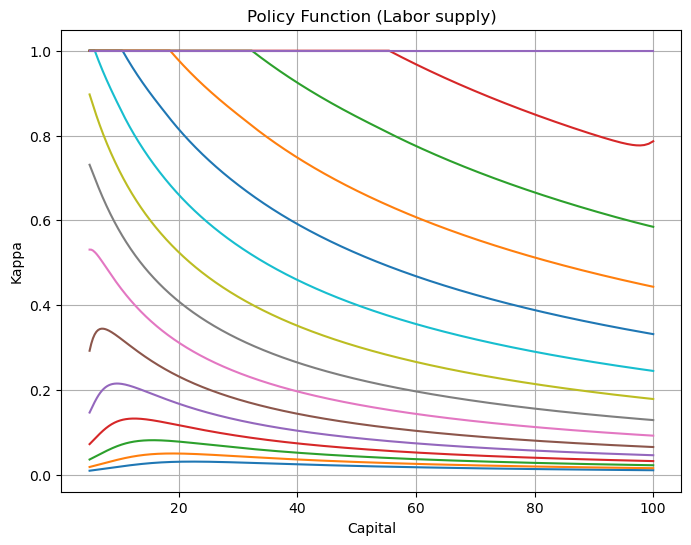

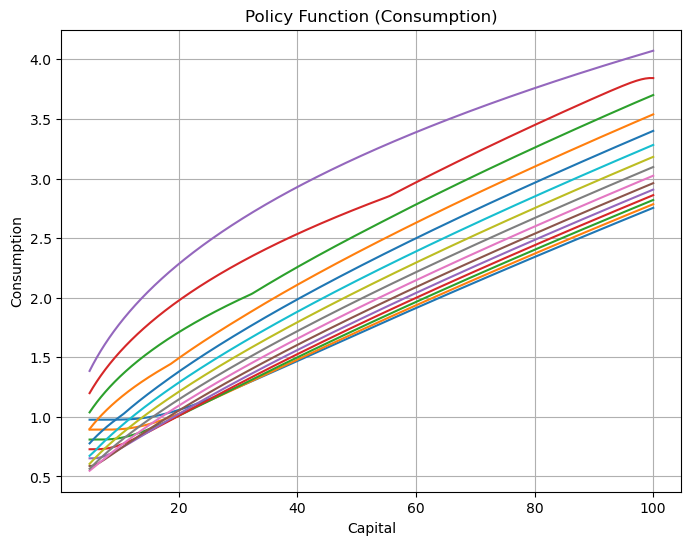

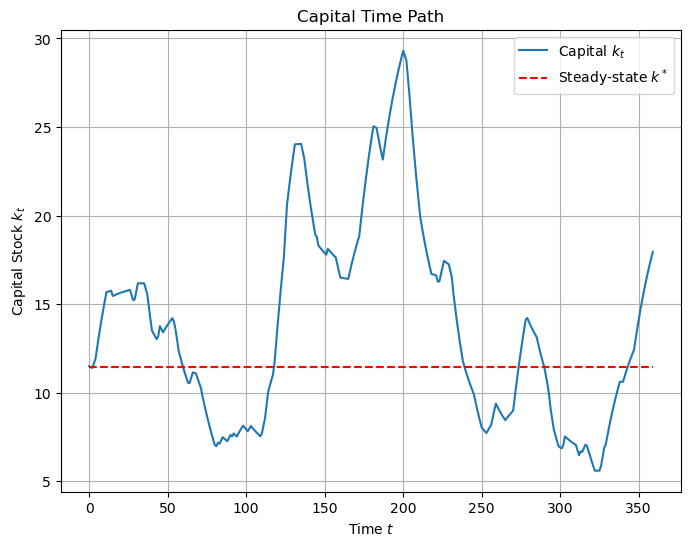

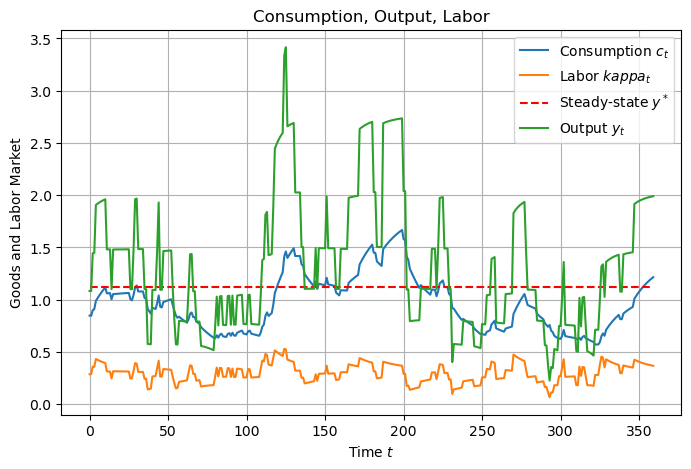

In [33]:
# Calculate the time path of consumption and capital numerically
#Simulate series of stochastic shocks
eta_t = np.zeros(TT)
shock_series = simulate_AR(pi, TT, 5)
c_interp = [CubicSpline(grid_k, c_new[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
kappa_interp = [CubicSpline(grid_k, kappa[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
k_t = np.zeros(TT)
kappa_t = np.zeros(TT)
c_t = np.zeros(TT)
i_t = np.zeros(TT)
y_t = np.zeros(TT)
k_t[0] = k0
eta_t[0] = 0
c_t[0] = c_interp[7](k_t[0])
kappa_t[0] = kappa_interp[7](k_t[0])
y_t[0] = np.exp(eta_t[0]) * ((k_t[0])**alpha) * ((kappa_t[0]*h0)**(1-alpha))
i_t[0] = y_t[0] - c_t[0]
for it in range(1, TT):
    state = shock_series[it]
    eta_t[it] = eta_grid[state]
    k_t[it] = max((1-delta)*k_t[it-1]+np.exp(eta_t[it-1])*(k_t[it-1]**alpha)*(kappa_t[it-1]*h0)**(1-alpha)-c_t[it-1],k_l)
    c_t[it] = max(c_interp[state](k_t[it]),1e-10)
    kappa_t[it] = np.clip(kappa_interp[state](k_t[it]), 1e-10, 1-1e-10)
    y_t[it] = np.exp(eta_t[it]) * ((k_t[it])**alpha) * ((kappa_t[it]*h0)**(1-alpha))
    i_t[it] = y_t[it] - c_t[it]

# Calculate steady states

hbar = ((1-alpha)*(1/beta-1+delta))/(((-A*(np.log(1-h0)))/h0)*(1/beta-1+delta-alpha*delta))
kbar = ((1/beta-1+delta)/alpha)**(1/(alpha-1))*hbar
ybar = np.exp(0)*kbar**alpha*hbar**(1-alpha)
cbar = -((np.exp(0)*(kbar/(hbar))**alpha*(1-alpha)*h0)/(A*np.log(1-h0)))
ibar = ybar-cbar

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, kappa)
plt.title("Policy Function (Labor supply)")
plt.xlabel("Capital")
plt.ylabel("Kappa")
plt.grid(True)
plt.show()

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, c_new)
plt.title("Policy Function (Consumption)")
plt.xlabel("Capital")
plt.ylabel("Consumption")
plt.grid(True)
plt.show()

# Plot time path of capital
plt.figure(figsize=(8, 6))
plt.plot(range(TT), k_t, label='Capital $k_t$')
plt.plot([0, TT-1], [kbar, kbar], 'r--', label='Steady-state $k^*$')
plt.xlabel('Time $t$')
plt.ylabel('Capital Stock $k_t$')
plt.legend()
plt.grid()
plt.title('Capital Time Path')
plt.show()

# Plot time paths for goods market
plt.figure(figsize=(8, 5))
plt.plot(range(TT), c_t, label='Consumption $c_t$')
plt.plot(range(TT), kappa_t*h0, label='Labor $kappa_t$')
plt.plot([0, TT-1], [ybar, ybar], 'r--', label='Steady-state $y^*$')
plt.plot(range(TT), y_t, label='Output $y_t$')
plt.xlabel('Time $t$')
plt.ylabel('Goods and Labor Market')
plt.legend()
plt.grid()
plt.title('Consumption, Output, Labor')
plt.show()